# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load utils/utilities.py
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

def standardize(train, test):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

	return X_train, X_test

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]
	






## Prepare data

In [3]:
rootDatasetDir = "./datasets/"
X_train, labels_train, list_ch_train = read_data(data_path=rootDatasetDir, split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path=rootDatasetDir, split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [4]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [5]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [6]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [7]:
# Imports
import tensorflow as tf

### Hyperparameters

In [8]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [9]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [10]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [11]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [12]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [13]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

('Epoch: 0/1000', 'Iteration: 5', 'Train loss: 1.792643', 'Train acc: 0.173333')
('Epoch: 1/1000', 'Iteration: 10', 'Train loss: 1.743583', 'Train acc: 0.196667')
('Epoch: 1/1000', 'Iteration: 10', 'Validation loss: 1.701915', 'Validation acc: 0.262222')
('Epoch: 1/1000', 'Iteration: 15', 'Train loss: 1.711187', 'Train acc: 0.185000')
('Epoch: 2/1000', 'Iteration: 20', 'Train loss: 1.661573', 'Train acc: 0.231667')
('Epoch: 2/1000', 'Iteration: 20', 'Validation loss: 1.635043', 'Validation acc: 0.304444')
('Epoch: 2/1000', 'Iteration: 25', 'Train loss: 1.639622', 'Train acc: 0.238333')
('Epoch: 3/1000', 'Iteration: 30', 'Train loss: 1.625769', 'Train acc: 0.248333')
('Epoch: 3/1000', 'Iteration: 30', 'Validation loss: 1.583182', 'Validation acc: 0.343889')
('Epoch: 3/1000', 'Iteration: 35', 'Train loss: 1.603398', 'Train acc: 0.243333')
('Epoch: 4/1000', 'Iteration: 40', 'Train loss: 1.570139', 'Train acc: 0.295000')
('Epoch: 4/1000', 'Iteration: 40', 'Validation loss: 1.535686', 'Vali

('Epoch: 36/1000', 'Iteration: 325', 'Train loss: 0.277182', 'Train acc: 0.916667')
('Epoch: 36/1000', 'Iteration: 330', 'Train loss: 0.256464', 'Train acc: 0.911667')
('Epoch: 36/1000', 'Iteration: 330', 'Validation loss: 0.241821', 'Validation acc: 0.922222')
('Epoch: 37/1000', 'Iteration: 335', 'Train loss: 0.278999', 'Train acc: 0.913333')
('Epoch: 37/1000', 'Iteration: 340', 'Train loss: 0.278778', 'Train acc: 0.910000')
('Epoch: 37/1000', 'Iteration: 340', 'Validation loss: 0.230945', 'Validation acc: 0.923333')
('Epoch: 38/1000', 'Iteration: 345', 'Train loss: 0.280316', 'Train acc: 0.895000')
('Epoch: 38/1000', 'Iteration: 350', 'Train loss: 0.235425', 'Train acc: 0.918333')
('Epoch: 38/1000', 'Iteration: 350', 'Validation loss: 0.221863', 'Validation acc: 0.925556')
('Epoch: 39/1000', 'Iteration: 355', 'Train loss: 0.275773', 'Train acc: 0.896667')
('Epoch: 39/1000', 'Iteration: 360', 'Train loss: 0.249885', 'Train acc: 0.935000')
('Epoch: 39/1000', 'Iteration: 360', 'Validati

('Epoch: 71/1000', 'Iteration: 640', 'Train loss: 0.135398', 'Train acc: 0.945000')
('Epoch: 71/1000', 'Iteration: 640', 'Validation loss: 0.130773', 'Validation acc: 0.952222')
('Epoch: 71/1000', 'Iteration: 645', 'Train loss: 0.123183', 'Train acc: 0.955000')
('Epoch: 72/1000', 'Iteration: 650', 'Train loss: 0.136523', 'Train acc: 0.955000')
('Epoch: 72/1000', 'Iteration: 650', 'Validation loss: 0.130303', 'Validation acc: 0.950556')
('Epoch: 72/1000', 'Iteration: 655', 'Train loss: 0.149814', 'Train acc: 0.946667')
('Epoch: 73/1000', 'Iteration: 660', 'Train loss: 0.163134', 'Train acc: 0.936667')
('Epoch: 73/1000', 'Iteration: 660', 'Validation loss: 0.128783', 'Validation acc: 0.952222')
('Epoch: 73/1000', 'Iteration: 665', 'Train loss: 0.109041', 'Train acc: 0.961667')
('Epoch: 74/1000', 'Iteration: 670', 'Train loss: 0.158212', 'Train acc: 0.938333')
('Epoch: 74/1000', 'Iteration: 670', 'Validation loss: 0.127981', 'Validation acc: 0.952222')
('Epoch: 74/1000', 'Iteration: 675',

('Epoch: 106/1000', 'Iteration: 955', 'Train loss: 0.107041', 'Train acc: 0.955000')
('Epoch: 106/1000', 'Iteration: 960', 'Train loss: 0.105125', 'Train acc: 0.955000')
('Epoch: 106/1000', 'Iteration: 960', 'Validation loss: 0.113589', 'Validation acc: 0.954444')
('Epoch: 107/1000', 'Iteration: 965', 'Train loss: 0.110199', 'Train acc: 0.955000')
('Epoch: 107/1000', 'Iteration: 970', 'Train loss: 0.119576', 'Train acc: 0.953333')
('Epoch: 107/1000', 'Iteration: 970', 'Validation loss: 0.113292', 'Validation acc: 0.955000')
('Epoch: 108/1000', 'Iteration: 975', 'Train loss: 0.141611', 'Train acc: 0.940000')
('Epoch: 108/1000', 'Iteration: 980', 'Train loss: 0.090042', 'Train acc: 0.966667')
('Epoch: 108/1000', 'Iteration: 980', 'Validation loss: 0.112911', 'Validation acc: 0.955000')
('Epoch: 109/1000', 'Iteration: 985', 'Train loss: 0.135347', 'Train acc: 0.941667')
('Epoch: 109/1000', 'Iteration: 990', 'Train loss: 0.128656', 'Train acc: 0.950000')
('Epoch: 109/1000', 'Iteration: 990

('Epoch: 140/1000', 'Iteration: 1265', 'Train loss: 0.103314', 'Train acc: 0.951667')
('Epoch: 141/1000', 'Iteration: 1270', 'Train loss: 0.093653', 'Train acc: 0.958333')
('Epoch: 141/1000', 'Iteration: 1270', 'Validation loss: 0.106706', 'Validation acc: 0.957222')
('Epoch: 141/1000', 'Iteration: 1275', 'Train loss: 0.097344', 'Train acc: 0.956667')
('Epoch: 142/1000', 'Iteration: 1280', 'Train loss: 0.099767', 'Train acc: 0.960000')
('Epoch: 142/1000', 'Iteration: 1280', 'Validation loss: 0.106700', 'Validation acc: 0.956667')
('Epoch: 142/1000', 'Iteration: 1285', 'Train loss: 0.109195', 'Train acc: 0.948333')
('Epoch: 143/1000', 'Iteration: 1290', 'Train loss: 0.124949', 'Train acc: 0.945000')
('Epoch: 143/1000', 'Iteration: 1290', 'Validation loss: 0.106441', 'Validation acc: 0.955000')
('Epoch: 143/1000', 'Iteration: 1295', 'Train loss: 0.082711', 'Train acc: 0.965000')
('Epoch: 144/1000', 'Iteration: 1300', 'Train loss: 0.130254', 'Train acc: 0.936667')
('Epoch: 144/1000', 'Ite

('Epoch: 174/1000', 'Iteration: 1575', 'Train loss: 0.114347', 'Train acc: 0.953333')
('Epoch: 175/1000', 'Iteration: 1580', 'Train loss: 0.099843', 'Train acc: 0.956667')
('Epoch: 175/1000', 'Iteration: 1580', 'Validation loss: 0.101798', 'Validation acc: 0.955000')
('Epoch: 176/1000', 'Iteration: 1585', 'Train loss: 0.089143', 'Train acc: 0.960000')
('Epoch: 176/1000', 'Iteration: 1590', 'Train loss: 0.093340', 'Train acc: 0.951667')
('Epoch: 176/1000', 'Iteration: 1590', 'Validation loss: 0.101460', 'Validation acc: 0.955000')
('Epoch: 177/1000', 'Iteration: 1595', 'Train loss: 0.097516', 'Train acc: 0.965000')
('Epoch: 177/1000', 'Iteration: 1600', 'Train loss: 0.101857', 'Train acc: 0.968333')
('Epoch: 177/1000', 'Iteration: 1600', 'Validation loss: 0.101193', 'Validation acc: 0.955000')
('Epoch: 178/1000', 'Iteration: 1605', 'Train loss: 0.121856', 'Train acc: 0.945000')
('Epoch: 178/1000', 'Iteration: 1610', 'Train loss: 0.069744', 'Train acc: 0.968333')
('Epoch: 178/1000', 'Ite

('Epoch: 209/1000', 'Iteration: 1885', 'Train loss: 0.115313', 'Train acc: 0.940000')
('Epoch: 209/1000', 'Iteration: 1890', 'Train loss: 0.104284', 'Train acc: 0.950000')
('Epoch: 209/1000', 'Iteration: 1890', 'Validation loss: 0.095779', 'Validation acc: 0.956111')
('Epoch: 210/1000', 'Iteration: 1895', 'Train loss: 0.095433', 'Train acc: 0.961667')
('Epoch: 211/1000', 'Iteration: 1900', 'Train loss: 0.082461', 'Train acc: 0.963333')
('Epoch: 211/1000', 'Iteration: 1900', 'Validation loss: 0.095963', 'Validation acc: 0.956667')
('Epoch: 211/1000', 'Iteration: 1905', 'Train loss: 0.083061', 'Train acc: 0.966667')
('Epoch: 212/1000', 'Iteration: 1910', 'Train loss: 0.086133', 'Train acc: 0.965000')
('Epoch: 212/1000', 'Iteration: 1910', 'Validation loss: 0.095318', 'Validation acc: 0.955555')
('Epoch: 212/1000', 'Iteration: 1915', 'Train loss: 0.093187', 'Train acc: 0.961667')
('Epoch: 213/1000', 'Iteration: 1920', 'Train loss: 0.122096', 'Train acc: 0.941667')
('Epoch: 213/1000', 'Ite

('Epoch: 243/1000', 'Iteration: 2195', 'Train loss: 0.064550', 'Train acc: 0.971667')
('Epoch: 244/1000', 'Iteration: 2200', 'Train loss: 0.109877', 'Train acc: 0.943333')
('Epoch: 244/1000', 'Iteration: 2200', 'Validation loss: 0.088152', 'Validation acc: 0.958333')
('Epoch: 244/1000', 'Iteration: 2205', 'Train loss: 0.091250', 'Train acc: 0.958333')
('Epoch: 245/1000', 'Iteration: 2210', 'Train loss: 0.093764', 'Train acc: 0.956667')
('Epoch: 245/1000', 'Iteration: 2210', 'Validation loss: 0.087923', 'Validation acc: 0.958333')
('Epoch: 246/1000', 'Iteration: 2215', 'Train loss: 0.072643', 'Train acc: 0.971667')
('Epoch: 246/1000', 'Iteration: 2220', 'Train loss: 0.074889', 'Train acc: 0.966667')
('Epoch: 246/1000', 'Iteration: 2220', 'Validation loss: 0.087739', 'Validation acc: 0.958333')
('Epoch: 247/1000', 'Iteration: 2225', 'Train loss: 0.083511', 'Train acc: 0.961667')
('Epoch: 247/1000', 'Iteration: 2230', 'Train loss: 0.089253', 'Train acc: 0.963333')
('Epoch: 247/1000', 'Ite

('Epoch: 278/1000', 'Iteration: 2505', 'Train loss: 0.100727', 'Train acc: 0.951667')
('Epoch: 278/1000', 'Iteration: 2510', 'Train loss: 0.054874', 'Train acc: 0.978333')
('Epoch: 278/1000', 'Iteration: 2510', 'Validation loss: 0.079489', 'Validation acc: 0.961111')
('Epoch: 279/1000', 'Iteration: 2515', 'Train loss: 0.093031', 'Train acc: 0.955000')
('Epoch: 279/1000', 'Iteration: 2520', 'Train loss: 0.089247', 'Train acc: 0.965000')
('Epoch: 279/1000', 'Iteration: 2520', 'Validation loss: 0.079431', 'Validation acc: 0.962222')
('Epoch: 280/1000', 'Iteration: 2525', 'Train loss: 0.077988', 'Train acc: 0.966667')
('Epoch: 281/1000', 'Iteration: 2530', 'Train loss: 0.065897', 'Train acc: 0.968333')
('Epoch: 281/1000', 'Iteration: 2530', 'Validation loss: 0.078987', 'Validation acc: 0.962222')
('Epoch: 281/1000', 'Iteration: 2535', 'Train loss: 0.067761', 'Train acc: 0.961667')
('Epoch: 282/1000', 'Iteration: 2540', 'Train loss: 0.072953', 'Train acc: 0.971667')
('Epoch: 282/1000', 'Ite

('Epoch: 312/1000', 'Iteration: 2815', 'Train loss: 0.068691', 'Train acc: 0.975000')
('Epoch: 313/1000', 'Iteration: 2820', 'Train loss: 0.090918', 'Train acc: 0.948333')
('Epoch: 313/1000', 'Iteration: 2820', 'Validation loss: 0.070925', 'Validation acc: 0.966667')
('Epoch: 313/1000', 'Iteration: 2825', 'Train loss: 0.042767', 'Train acc: 0.986667')
('Epoch: 314/1000', 'Iteration: 2830', 'Train loss: 0.084827', 'Train acc: 0.961667')
('Epoch: 314/1000', 'Iteration: 2830', 'Validation loss: 0.070500', 'Validation acc: 0.966667')
('Epoch: 314/1000', 'Iteration: 2835', 'Train loss: 0.072339', 'Train acc: 0.965000')
('Epoch: 315/1000', 'Iteration: 2840', 'Train loss: 0.068809', 'Train acc: 0.973333')
('Epoch: 315/1000', 'Iteration: 2840', 'Validation loss: 0.070280', 'Validation acc: 0.966667')
('Epoch: 316/1000', 'Iteration: 2845', 'Train loss: 0.058508', 'Train acc: 0.978333')
('Epoch: 316/1000', 'Iteration: 2850', 'Train loss: 0.055300', 'Train acc: 0.980000')
('Epoch: 316/1000', 'Ite

('Epoch: 347/1000', 'Iteration: 3125', 'Train loss: 0.053210', 'Train acc: 0.976667')
('Epoch: 347/1000', 'Iteration: 3130', 'Train loss: 0.057973', 'Train acc: 0.970000')
('Epoch: 347/1000', 'Iteration: 3130', 'Validation loss: 0.063987', 'Validation acc: 0.971111')
('Epoch: 348/1000', 'Iteration: 3135', 'Train loss: 0.071800', 'Train acc: 0.966667')
('Epoch: 348/1000', 'Iteration: 3140', 'Train loss: 0.037689', 'Train acc: 0.990000')
('Epoch: 348/1000', 'Iteration: 3140', 'Validation loss: 0.063584', 'Validation acc: 0.972778')
('Epoch: 349/1000', 'Iteration: 3145', 'Train loss: 0.070782', 'Train acc: 0.960000')
('Epoch: 349/1000', 'Iteration: 3150', 'Train loss: 0.060340', 'Train acc: 0.971667')
('Epoch: 349/1000', 'Iteration: 3150', 'Validation loss: 0.063757', 'Validation acc: 0.974444')
('Epoch: 350/1000', 'Iteration: 3155', 'Train loss: 0.062947', 'Train acc: 0.976667')
('Epoch: 351/1000', 'Iteration: 3160', 'Train loss: 0.051105', 'Train acc: 0.983333')
('Epoch: 351/1000', 'Ite

('Epoch: 381/1000', 'Iteration: 3435', 'Train loss: 0.043126', 'Train acc: 0.978333')
('Epoch: 382/1000', 'Iteration: 3440', 'Train loss: 0.047294', 'Train acc: 0.976667')
('Epoch: 382/1000', 'Iteration: 3440', 'Validation loss: 0.058672', 'Validation acc: 0.976667')
('Epoch: 382/1000', 'Iteration: 3445', 'Train loss: 0.057538', 'Train acc: 0.970000')
('Epoch: 383/1000', 'Iteration: 3450', 'Train loss: 0.061560', 'Train acc: 0.971667')
('Epoch: 383/1000', 'Iteration: 3450', 'Validation loss: 0.058463', 'Validation acc: 0.976667')
('Epoch: 383/1000', 'Iteration: 3455', 'Train loss: 0.032986', 'Train acc: 0.990000')
('Epoch: 384/1000', 'Iteration: 3460', 'Train loss: 0.070562', 'Train acc: 0.963333')
('Epoch: 384/1000', 'Iteration: 3460', 'Validation loss: 0.058227', 'Validation acc: 0.977778')
('Epoch: 384/1000', 'Iteration: 3465', 'Train loss: 0.055066', 'Train acc: 0.971667')
('Epoch: 385/1000', 'Iteration: 3470', 'Train loss: 0.055086', 'Train acc: 0.976667')
('Epoch: 385/1000', 'Ite

('Epoch: 416/1000', 'Iteration: 3745', 'Train loss: 0.041733', 'Train acc: 0.985000')
('Epoch: 416/1000', 'Iteration: 3750', 'Train loss: 0.037110', 'Train acc: 0.985000')
('Epoch: 416/1000', 'Iteration: 3750', 'Validation loss: 0.054749', 'Validation acc: 0.977778')
('Epoch: 417/1000', 'Iteration: 3755', 'Train loss: 0.040844', 'Train acc: 0.983333')
('Epoch: 417/1000', 'Iteration: 3760', 'Train loss: 0.053393', 'Train acc: 0.975000')
('Epoch: 417/1000', 'Iteration: 3760', 'Validation loss: 0.054530', 'Validation acc: 0.980556')
('Epoch: 418/1000', 'Iteration: 3765', 'Train loss: 0.057941', 'Train acc: 0.970000')
('Epoch: 418/1000', 'Iteration: 3770', 'Train loss: 0.027637', 'Train acc: 0.991667')
('Epoch: 418/1000', 'Iteration: 3770', 'Validation loss: 0.054662', 'Validation acc: 0.977778')
('Epoch: 419/1000', 'Iteration: 3775', 'Train loss: 0.063938', 'Train acc: 0.968333')
('Epoch: 419/1000', 'Iteration: 3780', 'Train loss: 0.049972', 'Train acc: 0.973333')
('Epoch: 419/1000', 'Ite

('Epoch: 450/1000', 'Iteration: 4055', 'Train loss: 0.046042', 'Train acc: 0.981667')
('Epoch: 451/1000', 'Iteration: 4060', 'Train loss: 0.038417', 'Train acc: 0.988333')
('Epoch: 451/1000', 'Iteration: 4060', 'Validation loss: 0.052146', 'Validation acc: 0.978333')
('Epoch: 451/1000', 'Iteration: 4065', 'Train loss: 0.033409', 'Train acc: 0.986667')
('Epoch: 452/1000', 'Iteration: 4070', 'Train loss: 0.035978', 'Train acc: 0.985000')
('Epoch: 452/1000', 'Iteration: 4070', 'Validation loss: 0.052095', 'Validation acc: 0.977778')
('Epoch: 452/1000', 'Iteration: 4075', 'Train loss: 0.039643', 'Train acc: 0.985000')
('Epoch: 453/1000', 'Iteration: 4080', 'Train loss: 0.057024', 'Train acc: 0.968333')
('Epoch: 453/1000', 'Iteration: 4080', 'Validation loss: 0.051614', 'Validation acc: 0.980000')
('Epoch: 453/1000', 'Iteration: 4085', 'Train loss: 0.022989', 'Train acc: 0.995000')
('Epoch: 454/1000', 'Iteration: 4090', 'Train loss: 0.060549', 'Train acc: 0.963333')
('Epoch: 454/1000', 'Ite

('Epoch: 484/1000', 'Iteration: 4365', 'Train loss: 0.039432', 'Train acc: 0.983333')
('Epoch: 485/1000', 'Iteration: 4370', 'Train loss: 0.043055', 'Train acc: 0.978333')
('Epoch: 485/1000', 'Iteration: 4370', 'Validation loss: 0.049709', 'Validation acc: 0.983333')
('Epoch: 486/1000', 'Iteration: 4375', 'Train loss: 0.032051', 'Train acc: 0.985000')
('Epoch: 486/1000', 'Iteration: 4380', 'Train loss: 0.027548', 'Train acc: 0.988333')
('Epoch: 486/1000', 'Iteration: 4380', 'Validation loss: 0.049359', 'Validation acc: 0.981111')
('Epoch: 487/1000', 'Iteration: 4385', 'Train loss: 0.036962', 'Train acc: 0.985000')
('Epoch: 487/1000', 'Iteration: 4390', 'Train loss: 0.032033', 'Train acc: 0.983333')
('Epoch: 487/1000', 'Iteration: 4390', 'Validation loss: 0.049729', 'Validation acc: 0.982222')
('Epoch: 488/1000', 'Iteration: 4395', 'Train loss: 0.048123', 'Train acc: 0.976667')
('Epoch: 488/1000', 'Iteration: 4400', 'Train loss: 0.021350', 'Train acc: 0.996667')
('Epoch: 488/1000', 'Ite

('Epoch: 519/1000', 'Iteration: 4675', 'Train loss: 0.050704', 'Train acc: 0.975000')
('Epoch: 519/1000', 'Iteration: 4680', 'Train loss: 0.030802', 'Train acc: 0.993333')
('Epoch: 519/1000', 'Iteration: 4680', 'Validation loss: 0.047578', 'Validation acc: 0.982222')
('Epoch: 520/1000', 'Iteration: 4685', 'Train loss: 0.036803', 'Train acc: 0.983333')
('Epoch: 521/1000', 'Iteration: 4690', 'Train loss: 0.028298', 'Train acc: 0.990000')
('Epoch: 521/1000', 'Iteration: 4690', 'Validation loss: 0.048030', 'Validation acc: 0.981667')
('Epoch: 521/1000', 'Iteration: 4695', 'Train loss: 0.025004', 'Train acc: 0.990000')
('Epoch: 522/1000', 'Iteration: 4700', 'Train loss: 0.029164', 'Train acc: 0.985000')
('Epoch: 522/1000', 'Iteration: 4700', 'Validation loss: 0.047725', 'Validation acc: 0.981667')
('Epoch: 522/1000', 'Iteration: 4705', 'Train loss: 0.030154', 'Train acc: 0.986667')
('Epoch: 523/1000', 'Iteration: 4710', 'Train loss: 0.042740', 'Train acc: 0.981667')
('Epoch: 523/1000', 'Ite

('Epoch: 553/1000', 'Iteration: 4985', 'Train loss: 0.017221', 'Train acc: 0.998333')
('Epoch: 554/1000', 'Iteration: 4990', 'Train loss: 0.047654', 'Train acc: 0.980000')
('Epoch: 554/1000', 'Iteration: 4990', 'Validation loss: 0.045289', 'Validation acc: 0.983333')
('Epoch: 554/1000', 'Iteration: 4995', 'Train loss: 0.032190', 'Train acc: 0.983333')
('Epoch: 555/1000', 'Iteration: 5000', 'Train loss: 0.035507', 'Train acc: 0.986667')
('Epoch: 555/1000', 'Iteration: 5000', 'Validation loss: 0.045545', 'Validation acc: 0.983889')
('Epoch: 556/1000', 'Iteration: 5005', 'Train loss: 0.030050', 'Train acc: 0.986667')
('Epoch: 556/1000', 'Iteration: 5010', 'Train loss: 0.026016', 'Train acc: 0.991667')
('Epoch: 556/1000', 'Iteration: 5010', 'Validation loss: 0.045097', 'Validation acc: 0.983333')
('Epoch: 557/1000', 'Iteration: 5015', 'Train loss: 0.023819', 'Train acc: 0.990000')
('Epoch: 557/1000', 'Iteration: 5020', 'Train loss: 0.026995', 'Train acc: 0.991667')
('Epoch: 557/1000', 'Ite

('Epoch: 588/1000', 'Iteration: 5295', 'Train loss: 0.034868', 'Train acc: 0.983333')
('Epoch: 588/1000', 'Iteration: 5300', 'Train loss: 0.012998', 'Train acc: 0.998333')
('Epoch: 588/1000', 'Iteration: 5300', 'Validation loss: 0.043235', 'Validation acc: 0.983333')
('Epoch: 589/1000', 'Iteration: 5305', 'Train loss: 0.039456', 'Train acc: 0.976667')
('Epoch: 589/1000', 'Iteration: 5310', 'Train loss: 0.027211', 'Train acc: 0.988333')
('Epoch: 589/1000', 'Iteration: 5310', 'Validation loss: 0.043378', 'Validation acc: 0.982778')
('Epoch: 590/1000', 'Iteration: 5315', 'Train loss: 0.030876', 'Train acc: 0.988333')
('Epoch: 591/1000', 'Iteration: 5320', 'Train loss: 0.026809', 'Train acc: 0.991667')
('Epoch: 591/1000', 'Iteration: 5320', 'Validation loss: 0.043575', 'Validation acc: 0.982778')
('Epoch: 591/1000', 'Iteration: 5325', 'Train loss: 0.019802', 'Train acc: 0.991667')
('Epoch: 592/1000', 'Iteration: 5330', 'Train loss: 0.022293', 'Train acc: 0.991667')
('Epoch: 592/1000', 'Ite

('Epoch: 622/1000', 'Iteration: 5605', 'Train loss: 0.022418', 'Train acc: 0.990000')
('Epoch: 623/1000', 'Iteration: 5610', 'Train loss: 0.033941', 'Train acc: 0.988333')
('Epoch: 623/1000', 'Iteration: 5610', 'Validation loss: 0.041725', 'Validation acc: 0.982778')
('Epoch: 623/1000', 'Iteration: 5615', 'Train loss: 0.014851', 'Train acc: 0.998333')
('Epoch: 624/1000', 'Iteration: 5620', 'Train loss: 0.032846', 'Train acc: 0.986667')
('Epoch: 624/1000', 'Iteration: 5620', 'Validation loss: 0.041510', 'Validation acc: 0.983333')
('Epoch: 624/1000', 'Iteration: 5625', 'Train loss: 0.027410', 'Train acc: 0.986667')
('Epoch: 625/1000', 'Iteration: 5630', 'Train loss: 0.027616', 'Train acc: 0.988333')
('Epoch: 625/1000', 'Iteration: 5630', 'Validation loss: 0.041456', 'Validation acc: 0.983889')
('Epoch: 626/1000', 'Iteration: 5635', 'Train loss: 0.026112', 'Train acc: 0.990000')
('Epoch: 626/1000', 'Iteration: 5640', 'Train loss: 0.021018', 'Train acc: 0.990000')
('Epoch: 626/1000', 'Ite

('Epoch: 657/1000', 'Iteration: 5915', 'Train loss: 0.017780', 'Train acc: 0.995000')
('Epoch: 657/1000', 'Iteration: 5920', 'Train loss: 0.020797', 'Train acc: 0.991667')
('Epoch: 657/1000', 'Iteration: 5920', 'Validation loss: 0.040411', 'Validation acc: 0.984444')
('Epoch: 658/1000', 'Iteration: 5925', 'Train loss: 0.035374', 'Train acc: 0.983333')
('Epoch: 658/1000', 'Iteration: 5930', 'Train loss: 0.012490', 'Train acc: 0.998333')
('Epoch: 658/1000', 'Iteration: 5930', 'Validation loss: 0.039991', 'Validation acc: 0.984444')
('Epoch: 659/1000', 'Iteration: 5935', 'Train loss: 0.036249', 'Train acc: 0.983333')
('Epoch: 659/1000', 'Iteration: 5940', 'Train loss: 0.022709', 'Train acc: 0.988333')
('Epoch: 659/1000', 'Iteration: 5940', 'Validation loss: 0.039912', 'Validation acc: 0.985000')
('Epoch: 660/1000', 'Iteration: 5945', 'Train loss: 0.023898', 'Train acc: 0.990000')
('Epoch: 661/1000', 'Iteration: 5950', 'Train loss: 0.020759', 'Train acc: 0.991667')
('Epoch: 661/1000', 'Ite

('Epoch: 691/1000', 'Iteration: 6225', 'Train loss: 0.015373', 'Train acc: 0.993333')
('Epoch: 692/1000', 'Iteration: 6230', 'Train loss: 0.014099', 'Train acc: 0.996667')
('Epoch: 692/1000', 'Iteration: 6230', 'Validation loss: 0.039021', 'Validation acc: 0.985000')
('Epoch: 692/1000', 'Iteration: 6235', 'Train loss: 0.018425', 'Train acc: 0.993333')
('Epoch: 693/1000', 'Iteration: 6240', 'Train loss: 0.027717', 'Train acc: 0.986667')
('Epoch: 693/1000', 'Iteration: 6240', 'Validation loss: 0.038295', 'Validation acc: 0.985556')
('Epoch: 693/1000', 'Iteration: 6245', 'Train loss: 0.010002', 'Train acc: 0.998333')
('Epoch: 694/1000', 'Iteration: 6250', 'Train loss: 0.030928', 'Train acc: 0.985000')
('Epoch: 694/1000', 'Iteration: 6250', 'Validation loss: 0.038451', 'Validation acc: 0.985000')
('Epoch: 694/1000', 'Iteration: 6255', 'Train loss: 0.018590', 'Train acc: 0.995000')
('Epoch: 695/1000', 'Iteration: 6260', 'Train loss: 0.024273', 'Train acc: 0.993333')
('Epoch: 695/1000', 'Ite

('Epoch: 726/1000', 'Iteration: 6535', 'Train loss: 0.018305', 'Train acc: 0.996667')
('Epoch: 726/1000', 'Iteration: 6540', 'Train loss: 0.014519', 'Train acc: 0.991667')
('Epoch: 726/1000', 'Iteration: 6540', 'Validation loss: 0.036945', 'Validation acc: 0.985556')
('Epoch: 727/1000', 'Iteration: 6545', 'Train loss: 0.013551', 'Train acc: 0.995000')
('Epoch: 727/1000', 'Iteration: 6550', 'Train loss: 0.018052', 'Train acc: 0.991667')
('Epoch: 727/1000', 'Iteration: 6550', 'Validation loss: 0.037223', 'Validation acc: 0.986111')
('Epoch: 728/1000', 'Iteration: 6555', 'Train loss: 0.029274', 'Train acc: 0.986667')
('Epoch: 728/1000', 'Iteration: 6560', 'Train loss: 0.008642', 'Train acc: 0.998333')
('Epoch: 728/1000', 'Iteration: 6560', 'Validation loss: 0.037761', 'Validation acc: 0.986111')
('Epoch: 729/1000', 'Iteration: 6565', 'Train loss: 0.028165', 'Train acc: 0.990000')
('Epoch: 729/1000', 'Iteration: 6570', 'Train loss: 0.015963', 'Train acc: 0.995000')
('Epoch: 729/1000', 'Ite

('Epoch: 760/1000', 'Iteration: 6845', 'Train loss: 0.020612', 'Train acc: 0.993333')
('Epoch: 761/1000', 'Iteration: 6850', 'Train loss: 0.014261', 'Train acc: 0.998333')
('Epoch: 761/1000', 'Iteration: 6850', 'Validation loss: 0.037910', 'Validation acc: 0.987778')
('Epoch: 761/1000', 'Iteration: 6855', 'Train loss: 0.014296', 'Train acc: 0.990000')
('Epoch: 762/1000', 'Iteration: 6860', 'Train loss: 0.011318', 'Train acc: 0.996667')
('Epoch: 762/1000', 'Iteration: 6860', 'Validation loss: 0.036874', 'Validation acc: 0.987222')
('Epoch: 762/1000', 'Iteration: 6865', 'Train loss: 0.012987', 'Train acc: 0.995000')
('Epoch: 763/1000', 'Iteration: 6870', 'Train loss: 0.024601', 'Train acc: 0.991667')
('Epoch: 763/1000', 'Iteration: 6870', 'Validation loss: 0.035996', 'Validation acc: 0.987222')
('Epoch: 763/1000', 'Iteration: 6875', 'Train loss: 0.010086', 'Train acc: 0.998333')
('Epoch: 764/1000', 'Iteration: 6880', 'Train loss: 0.025593', 'Train acc: 0.990000')
('Epoch: 764/1000', 'Ite

('Epoch: 794/1000', 'Iteration: 7155', 'Train loss: 0.013410', 'Train acc: 1.000000')
('Epoch: 795/1000', 'Iteration: 7160', 'Train loss: 0.020223', 'Train acc: 0.996667')
('Epoch: 795/1000', 'Iteration: 7160', 'Validation loss: 0.034971', 'Validation acc: 0.987778')
('Epoch: 796/1000', 'Iteration: 7165', 'Train loss: 0.015058', 'Train acc: 0.996667')
('Epoch: 796/1000', 'Iteration: 7170', 'Train loss: 0.011389', 'Train acc: 0.996667')
('Epoch: 796/1000', 'Iteration: 7170', 'Validation loss: 0.034123', 'Validation acc: 0.987222')
('Epoch: 797/1000', 'Iteration: 7175', 'Train loss: 0.007630', 'Train acc: 0.998333')
('Epoch: 797/1000', 'Iteration: 7180', 'Train loss: 0.011837', 'Train acc: 0.995000')
('Epoch: 797/1000', 'Iteration: 7180', 'Validation loss: 0.033811', 'Validation acc: 0.988889')
('Epoch: 798/1000', 'Iteration: 7185', 'Train loss: 0.021813', 'Train acc: 0.991667')
('Epoch: 798/1000', 'Iteration: 7190', 'Train loss: 0.009604', 'Train acc: 0.996667')
('Epoch: 798/1000', 'Ite

('Epoch: 829/1000', 'Iteration: 7465', 'Train loss: 0.018344', 'Train acc: 0.993333')
('Epoch: 829/1000', 'Iteration: 7470', 'Train loss: 0.010429', 'Train acc: 1.000000')
('Epoch: 829/1000', 'Iteration: 7470', 'Validation loss: 0.033747', 'Validation acc: 0.990556')
('Epoch: 830/1000', 'Iteration: 7475', 'Train loss: 0.014719', 'Train acc: 0.998333')
('Epoch: 831/1000', 'Iteration: 7480', 'Train loss: 0.010797', 'Train acc: 0.996667')
('Epoch: 831/1000', 'Iteration: 7480', 'Validation loss: 0.033776', 'Validation acc: 0.991111')
('Epoch: 831/1000', 'Iteration: 7485', 'Train loss: 0.009010', 'Train acc: 0.996667')
('Epoch: 832/1000', 'Iteration: 7490', 'Train loss: 0.010148', 'Train acc: 0.996667')
('Epoch: 832/1000', 'Iteration: 7490', 'Validation loss: 0.034251', 'Validation acc: 0.989444')
('Epoch: 832/1000', 'Iteration: 7495', 'Train loss: 0.011075', 'Train acc: 0.995000')
('Epoch: 833/1000', 'Iteration: 7500', 'Train loss: 0.018945', 'Train acc: 0.995000')
('Epoch: 833/1000', 'Ite

('Epoch: 863/1000', 'Iteration: 7775', 'Train loss: 0.005646', 'Train acc: 0.998333')
('Epoch: 864/1000', 'Iteration: 7780', 'Train loss: 0.017394', 'Train acc: 0.995000')
('Epoch: 864/1000', 'Iteration: 7780', 'Validation loss: 0.033098', 'Validation acc: 0.992222')
('Epoch: 864/1000', 'Iteration: 7785', 'Train loss: 0.010940', 'Train acc: 0.995000')
('Epoch: 865/1000', 'Iteration: 7790', 'Train loss: 0.015002', 'Train acc: 0.996667')
('Epoch: 865/1000', 'Iteration: 7790', 'Validation loss: 0.033039', 'Validation acc: 0.992778')
('Epoch: 866/1000', 'Iteration: 7795', 'Train loss: 0.012542', 'Train acc: 0.996667')
('Epoch: 866/1000', 'Iteration: 7800', 'Train loss: 0.008576', 'Train acc: 0.998333')
('Epoch: 866/1000', 'Iteration: 7800', 'Validation loss: 0.034244', 'Validation acc: 0.990556')
('Epoch: 867/1000', 'Iteration: 7805', 'Train loss: 0.010067', 'Train acc: 0.998333')
('Epoch: 867/1000', 'Iteration: 7810', 'Train loss: 0.012491', 'Train acc: 0.995000')
('Epoch: 867/1000', 'Ite

('Epoch: 898/1000', 'Iteration: 8085', 'Train loss: 0.015965', 'Train acc: 0.993333')
('Epoch: 898/1000', 'Iteration: 8090', 'Train loss: 0.006037', 'Train acc: 0.998333')
('Epoch: 898/1000', 'Iteration: 8090', 'Validation loss: 0.033002', 'Validation acc: 0.991111')
('Epoch: 899/1000', 'Iteration: 8095', 'Train loss: 0.016872', 'Train acc: 0.995000')
('Epoch: 899/1000', 'Iteration: 8100', 'Train loss: 0.008279', 'Train acc: 1.000000')
('Epoch: 899/1000', 'Iteration: 8100', 'Validation loss: 0.032571', 'Validation acc: 0.992778')
('Epoch: 900/1000', 'Iteration: 8105', 'Train loss: 0.012635', 'Train acc: 0.996667')
('Epoch: 901/1000', 'Iteration: 8110', 'Train loss: 0.010650', 'Train acc: 0.996667')
('Epoch: 901/1000', 'Iteration: 8110', 'Validation loss: 0.032383', 'Validation acc: 0.992778')
('Epoch: 901/1000', 'Iteration: 8115', 'Train loss: 0.008179', 'Train acc: 1.000000')
('Epoch: 902/1000', 'Iteration: 8120', 'Train loss: 0.007092', 'Train acc: 0.998333')
('Epoch: 902/1000', 'Ite

('Epoch: 932/1000', 'Iteration: 8395', 'Train loss: 0.011181', 'Train acc: 0.995000')
('Epoch: 933/1000', 'Iteration: 8400', 'Train loss: 0.016021', 'Train acc: 0.993333')
('Epoch: 933/1000', 'Iteration: 8400', 'Validation loss: 0.032653', 'Validation acc: 0.992778')
('Epoch: 933/1000', 'Iteration: 8405', 'Train loss: 0.007414', 'Train acc: 0.998333')
('Epoch: 934/1000', 'Iteration: 8410', 'Train loss: 0.012400', 'Train acc: 0.996667')
('Epoch: 934/1000', 'Iteration: 8410', 'Validation loss: 0.033126', 'Validation acc: 0.992778')
('Epoch: 934/1000', 'Iteration: 8415', 'Train loss: 0.009419', 'Train acc: 0.998333')
('Epoch: 935/1000', 'Iteration: 8420', 'Train loss: 0.012185', 'Train acc: 0.995000')
('Epoch: 935/1000', 'Iteration: 8420', 'Validation loss: 0.033224', 'Validation acc: 0.992778')
('Epoch: 936/1000', 'Iteration: 8425', 'Train loss: 0.008715', 'Train acc: 0.998333')
('Epoch: 936/1000', 'Iteration: 8430', 'Train loss: 0.007660', 'Train acc: 0.996667')
('Epoch: 936/1000', 'Ite

('Epoch: 967/1000', 'Iteration: 8705', 'Train loss: 0.007116', 'Train acc: 0.998333')
('Epoch: 967/1000', 'Iteration: 8710', 'Train loss: 0.005543', 'Train acc: 1.000000')
('Epoch: 967/1000', 'Iteration: 8710', 'Validation loss: 0.035638', 'Validation acc: 0.991667')
('Epoch: 968/1000', 'Iteration: 8715', 'Train loss: 0.013189', 'Train acc: 0.995000')
('Epoch: 968/1000', 'Iteration: 8720', 'Train loss: 0.005112', 'Train acc: 0.998333')
('Epoch: 968/1000', 'Iteration: 8720', 'Validation loss: 0.035170', 'Validation acc: 0.992222')
('Epoch: 969/1000', 'Iteration: 8725', 'Train loss: 0.011546', 'Train acc: 0.996667')
('Epoch: 969/1000', 'Iteration: 8730', 'Train loss: 0.005710', 'Train acc: 1.000000')
('Epoch: 969/1000', 'Iteration: 8730', 'Validation loss: 0.033005', 'Validation acc: 0.992778')
('Epoch: 970/1000', 'Iteration: 8735', 'Train loss: 0.009700', 'Train acc: 0.998333')
('Epoch: 971/1000', 'Iteration: 8740', 'Train loss: 0.006087', 'Train acc: 0.998333')
('Epoch: 971/1000', 'Ite

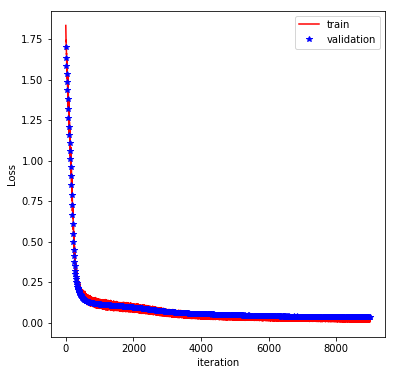

In [14]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

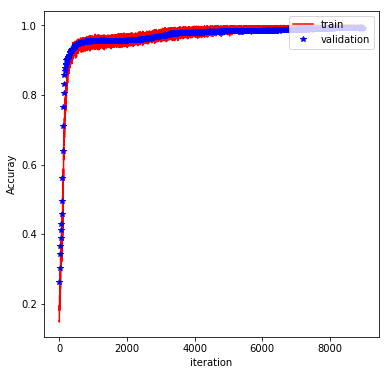

In [15]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [16]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.931250
